In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def fast_thinning(img):
    skel = np.zeros(img.shape, np.uint8)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    while True:
        open = cv2.morphologyEx(img, cv2.MORPH_OPEN, element)
        temp = img - open
        eroded = cv2.erode(img, element)
        skel = cv2.bitwise_or(skel, temp)
        img = eroded.copy()
        if cv2.countNonZero(img) == 0:
            break
    return skel

def find_distance(x0, y0, direction, binary_img):
    step_size = 8  # Empezar con un paso grande
    current_dist = 0
    dir_x, dir_y = direction
    while step_size >= 1:
        new_x = int(x0 + dir_x * (current_dist + step_size))
        new_y = int(y0 + dir_y * (current_dist + step_size))
        if (0 <= new_x < binary_img.shape[1] and 
            0 <= new_y < binary_img.shape[0] and 
            binary_img[new_y, new_x]):
            current_dist += step_size
        else:
            step_size //= 2
    return current_dist


In [14]:
# img_path = 'testing/inference_dem_2/class_epoch_79.png'
# img = cv2.imread(img_path)
# img = img[:,:,::-1]
# img_red = img[:, :, 0]
# img_green = img[:, :, 1]
# img_blue = img[:, :, 2]

# # Crear una máscara binaria para detectar píxeles con color verde puro
# green_mask = np.logical_and(img_green > img_red, img_green > img_blue)
# binary_img = green_mask.astype(np.uint8) * 255

# # Operaciones morfológicas optimizadas
# binary_img = cv2.medianBlur(binary_img, 3)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
# binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel, iterations=2)
# binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel, iterations=1)

# # Análisis de conectividad con filtrado temprano
# num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_img, connectivity=8)
# valid_components = [i for i in range(1, num_labels) if stats[i, cv2.CC_STAT_AREA] > 150]

# step = 2
# result = []

# for i in valid_components:
#     mask = (labels == i).astype(np.uint8)
#     skeleton = fast_thinning(mask)
#     y_coords, x_coords = np.where(skeleton > 0)

#     for i in range(0, len(y_coords), 10):
#         if i + 10 < len(y_coords):
#             x1, y1 = x_coords[i], y_coords[i]
#             x2, y2 = x_coords[i+10], y_coords[i+10]

#             if x2 != x1:
#                 m = (y2 - y1) / (x2 - x1)
#                 angle = np.arctan(m) + np.radians(90)
#                 direcction_up = np.array([np.cos(angle), np.sin(angle)])
#                 direcction_down = -direcction_up

#                 i_up = 1
#                 i_down = 1
#                 d_up = 0
#                 d_down = 0

#                 while d_up == 0 or d_down == 0:
#                     if d_up == 0:
#                         mov_step_up = direcction_up * i_up * step
#                         new_pos_up = (x1, y1) + mov_step_up
#                         if binary_img[int(new_pos_up[1]), int(new_pos_up[0])] == 0:
#                             d_up = (i_up - 1) * step
#                         else:
#                             i_up += 1

#                     if d_down == 0:
#                         mov_step_down = direcction_down * i_down * step
#                         new_pos_down = (x1, y1) + mov_step_down
#                         if binary_img[int(new_pos_down[1]), int(new_pos_down[0])] == 0:
#                             d_down = (i_down - 1) * step
#                         else:
#                             i_down += 1

#                 result.append((x1, x2, (d_up + d_down)))
#                 print(f"pos: {(x1, y1)}, new_pos: {(new_pos_up, new_pos_down)}, d: {(d_up + d_down)*0.25}")
#             else:
#                 print("Vertical line, slope is undefined")

#     break
# plt.imshow(skeleton)
# plt.show()

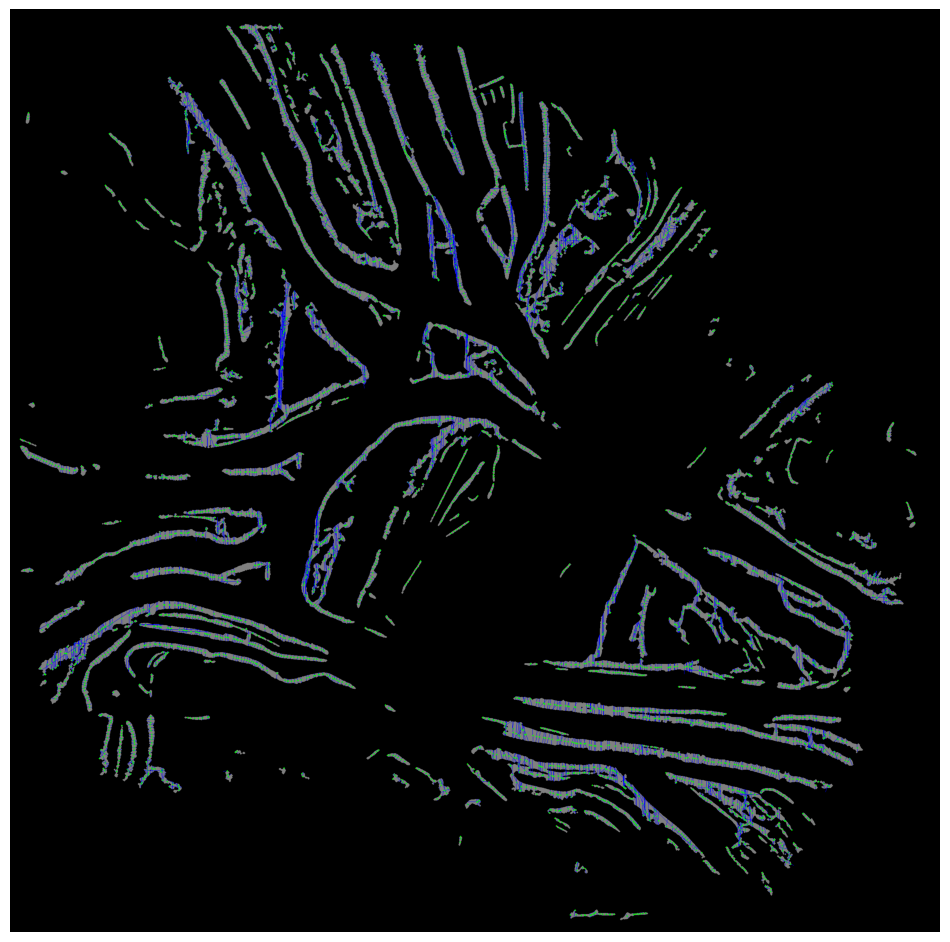

In [ ]:
# Cargar imagen y extraer canales
img = cv2.imread('testing/inference_dem_1/class_epoch_99.png', cv2.IMREAD_COLOR)

img_green = img[:, :, 1]  
img_red = img[:, :, 2]
img_blue = img[:, :, 0]

# Crear máscara verde optimizada
green_mask = (img_green > img_red) & (img_green > img_blue)
binary_img = np.uint8(green_mask) * 255

# Operaciones morfológicas 
binary_img = cv2.medianBlur(binary_img, 3)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel, iterations=2)
binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel, iterations=1)

# Análisis de conectividad
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_img, 8)
valid_components = [i for i in range(1, num_labels) if stats[i, cv2.CC_STAT_AREA] > 150]

# Precalcular máscara booleana para accesos más rápidos
binary_mask = binary_img.astype(bool)
results = []

# Crear imagen para visualización
visualization_img = np.zeros((binary_img.shape[0], binary_img.shape[1], 3), dtype=np.uint8)

for component in valid_components:
    mask = (labels == component).astype(np.uint8)
    skeleton = fast_thinning(mask).astype(np.uint8)
    y_coords, x_coords = np.nonzero(skeleton)
    
    # Dibujar esqueleto en gris
    visualization_img[mask.astype(bool)] = [128, 128, 128]
    
    # Procesar cada 10 puntos usando slicing de numpy
    for i in range(0, len(y_coords), 10):
        if i + 10 >= len(y_coords):
            continue
        x1, y1 = x_coords[i], y_coords[i]
        x2, y2 = x_coords[i+10], y_coords[i+10]
        
        dx = x2 - x1
        dy = y2 - y1
        length = np.hypot(dx, dy)
        
        if length == 0:
            continue
        
        # Calcular dirección perpendicular
        dir_up = (-dy/length, dx/length)
        dir_down = (dy/length, -dx/length)
        
        # Calcular distancias con búsqueda binaria
        d_up = find_distance(x1, y1, dir_up, binary_mask)
        d_down = find_distance(x1, y1, dir_down, binary_mask)
        
        results.append(((x1, y1), (d_up + d_down) * 0.25))

        # Calcular puntos extremos de la línea
        start_x = int(x1 - dir_up[0] * d_down)
        start_y = int(y1 - dir_up[1] * d_down)
        end_x = int(x1 + dir_up[0] * d_up)
        end_y = int(y1 + dir_up[1] * d_up)
        
        # Dibujar línea en rojo
        cv2.line(visualization_img, 
                (start_x, start_y), 
                (end_x, end_y), 
                (0, 0, 255), 1)
        
        cv2.circle(visualization_img, (x1, y1), 2, (0, 255, 0), -1)

# Mostrar resultado
plt.figure(figsize=(12, 12))
plt.imshow(visualization_img)
plt.axis('off')
plt.show()

In [16]:
results

[((np.int64(735), np.int64(41)), 6.75),
 ((np.int64(641), np.int64(48)), 3.0),
 ((np.int64(628), np.int64(49)), 1.0),
 ((np.int64(671), np.int64(49)), 10.5),
 ((np.int64(699), np.int64(49)), 1.25),
 ((np.int64(635), np.int64(50)), 2.5),
 ((np.int64(697), np.int64(50)), 1.25),
 ((np.int64(718), np.int64(50)), 3.0),
 ((np.int64(653), np.int64(51)), 6.0),
 ((np.int64(726), np.int64(51)), 2.5),
 ((np.int64(742), np.int64(52)), 2.0),
 ((np.int64(659), np.int64(55)), 6.0),
 ((np.int64(716), np.int64(57)), 4.25),
 ((np.int64(667), np.int64(63)), 5.0),
 ((np.int64(671), np.int64(68)), 4.5),
 ((np.int64(677), np.int64(77)), 4.0),
 ((np.int64(681), np.int64(83)), 4.0),
 ((np.int64(686), np.int64(91)), 3.5),
 ((np.int64(687), np.int64(98)), 87.75),
 ((np.int64(670), np.int64(104)), 2.25),
 ((np.int64(668), np.int64(107)), 4.0),
 ((np.int64(692), np.int64(112)), 4.0),
 ((np.int64(697), np.int64(123)), 4.0),
 ((np.int64(703), np.int64(131)), 3.75),
 ((np.int64(704), np.int64(140)), 4.5),
 ((np.int6